In [1]:
import numpy as np 
import pandas as pd 
import re
import nltk 
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.corpus import stopwords
#nltk.download('punkt')
#nltk.download()
from nltk.stem import PorterStemmer  


data = "Womens Clothing E-Commerce Reviews.csv"
reviews = pd.read_csv(data)
#reviews.head()

In [2]:
#label each review either as positive or negative according to their rating
#replace values: those which are rated with value from 1 to 3 as 0(negative) and from4 to 5 as 1(positive).
reviews['Rating'].replace([1],[0],inplace=True) 
reviews['Rating'].replace([2],[0],inplace=True)
reviews['Rating'].replace([3],[0],inplace=True)
reviews['Rating'].replace([4],[1],inplace=True)
reviews['Rating'].replace([5],[1],inplace=True)                           

In [3]:
#change the name of column "Rating" to "Polarity", since now it contains the polarity values, 0 or 1.
reviews.rename(columns={'Rating':'Polarity'}, inplace=True)

In [4]:
#save the three columns we will work with in a new dataframe
header = ['Age','Review Text','Polarity']
reviews.to_csv('output.csv', columns = header)

In [5]:
dataset = pd.read_csv('output.csv') #extract and save in a new file the three columns that construct the main dataset
#dataset.head()

In [6]:
#replace empty cells in the column with Nan values
dataset['Review Text'].replace('', np.nan, inplace=True) 
dataset.dropna(subset=['Review Text'], inplace=True) #remove all the Nan values, it removes also automaticall the whole row

In [7]:
remove = ['Unnamed: 0'] #drop this column
dataset.drop(remove, axis = 1, inplace=True)
#dataset.head()

In [8]:
dataset.to_csv('final_dataset.csv', index=False)

In [9]:
data = pd.read_csv('final_dataset.csv')

data.rename(columns={'Review Text':'ReviewText'}, inplace=True)

In [10]:
#### Preprocessing step ####

import matplotlib.pyplot as plt

data['ReviewText'] = data['ReviewText'].str.lower() #lowercase

#Tokenization
def tokenized(row):
    review = row['ReviewText']
    tokens = nltk.word_tokenize(review)
    # remove punctuation and numbers
    tokenized_words = [w for w in tokens if w.isalpha()]
    return tokenized_words

data['words'] = data.apply(tokenized, axis=1)


#Stemming
stemmer = PorterStemmer()

def stem_list(row):
    lst = row['words']
    stemmed = [stemmer.stem(word) for word in lst]
    return (stemmed)

data['stemmed_words'] = data.apply(stem_list, axis=1)

#Removal of Stopwords
stop_words = set(stopwords.words("english"))                  

def remove_stopwords(row):
    my_list = row['stemmed_words']
    Nostopwords = [w for w in my_list if not w in stop_words]
    return (Nostopwords)

data['NoStops'] = data.apply(remove_stopwords, axis=1)


#Join stemmed words into a new column
def rejoin_words(row):
    my_list = row['NoStops']
    joined_words = ( " ".join(my_list))
    return joined_words

data['ProcessedWords'] = data.apply(rejoin_words, axis=1)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
drops = ['ReviewText', 'words', 'stemmed_words', 'NoStops'] #drop these columns
data.drop(drops, axis = 1, inplace=True)
data.to_csv('Reviews_processed.csv', index=False)

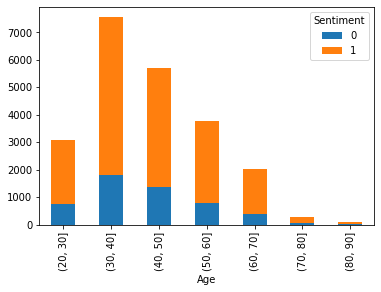

In [14]:
#Dealing with impalanced dataset

from sklearn.utils import resample
import seaborn as sns
reviews = pd.read_csv('Reviews_processed.csv')




#Choose oversampling technique to balance the imbalanced dataset. This means that samples from the minority class
#will be replicated randomly in order to match the majority class

#Divide by class
reviews_majority = reviews[reviews.Polarity == 1] # Majority Class
reviews_minority = reviews[reviews.Polarity == 0] # Minority Class

#upsampling minority class / with replacement to match majority class, so each classes will contain 17448 samples 
reviews_minority_upsampled = resample(reviews_minority,
                                      replace=True,
                                      n_samples=17448,
                                      random_state=123)


reviews_upsampled = pd.concat([reviews_majority, reviews_minority_upsampled]) #combine majority class with upsampled minority one
reviews_upsampled.Polarity.value_counts() #count classes. Each class now contains 17448 reviews.

#### Computing the relation between Age and Sentiment for specific age ranges ####

reviews.rename(columns={'Polarity':'Sentiment'}, inplace=True)
bins = pd.cut(reviews['Age'], [20, 30, 40, 50, 60, 70, 80, 90]) 
#the x-axis represents the age groups (per decade)
reviews.groupby([bins, 'Sentiment']).size().unstack().plot(kind='bar',stacked=True)


In [27]:
#### Feature Extraction ####
#BagofWords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from scipy.sparse import csr_matrix
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE


#labels correspond to 0 and 1.
labels = reviews_upsampled.Polarity.values
#features are related to text features and age features
features = reviews_upsampled[['ProcessedWords','Age']].copy()

#divide the dataset into 70% training set and 30% test set
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=0)

#Column Transformer() generates each type of feature separately and then concatenates them into a single feature space
preprocess = ColumnTransformer(
    [('TextFeatures', CountVectorizer(ngram_range=(4, 4)), 'ProcessedWords'),
    ('AgeFeatures', OneHotEncoder(dtype='int', handle_unknown='ignore'), ['Age'])],remainder = 'passthrough')

#Text feeatures are converted into numerical values with CountVectorizer()
#Age features are treated as categorical values




SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
model score: 0.949


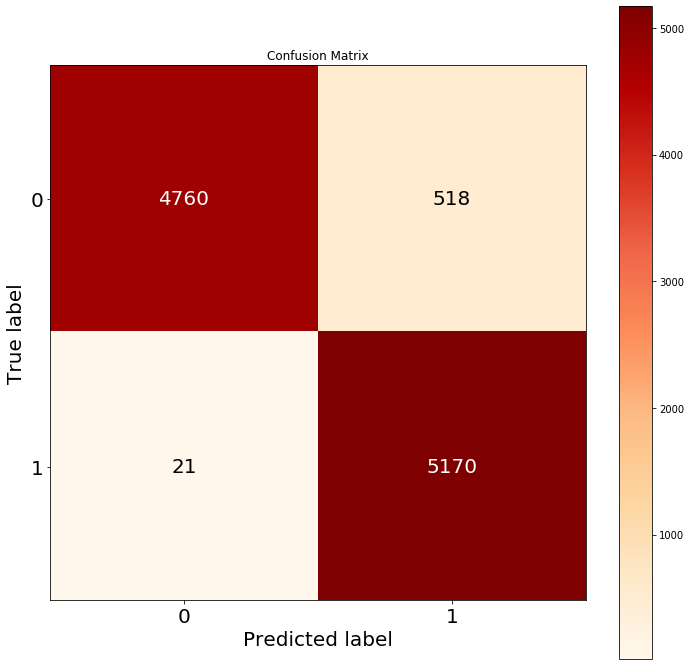

In [35]:
#### Training of Classifiers and Evaluation ####

from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
import scikitplot as skplt


classifiers = [
    MultinomialNB(),
    LogisticRegression(solver='liblinear'),
    RandomForestClassifier(),
    SVC(kernel = 'linear')
]


for classifier in classifiers:
    model = Pipeline(steps=[('preprocess', preprocess),('classifier', classifier)])
    model.fit(X_train, y_train)  
    print(classifier)
    print("model score: %.3f" % model.score(X_test, y_test))
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    #visualization of confusion matrix
    skplt.metrics.plot_confusion_matrix(y_test, y_pred, figsize=(12,12), cmap='OrRd', title_fontsize = 'large', text_fontsize = 20)
    

